In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.frequent_patterns import apriori, association_rules

In [2]:
df = pd.read_csv("games_march2025_cleaned.csv", on_bad_lines='skip')

In [3]:
pd.read_csv("games_march2025_cleaned.csv").head()

,appid,name,release_date,required_age,price,dlc_count,detailed_description,about_the_game,short_description,reviews,...,average_playtime_2weeks,median_playtime_forever,median_playtime_2weeks,discount,peak_ccu,tags,pct_pos_total,num_reviews_total,pct_pos_recent,num_reviews_recent
0,730,Counter-Strike 2,2012-08-21,0,0.00,1,"For over two decades, Counter-Strike has offer...","For over two decades, Counter-Strike has offer...","For over two decades, Counter-Strike has offer...",NaN,...,879,5174,350,0,1212356,"{'FPS': 90857, 'Shooter': 65397, 'Multiplayer'...",86,8632939,82,96473
1,578080,PUBG: BATTLEGROUNDS,2017-12-21,0,0.00,0,"LAND, LOOT, SURVIVE! Play PUBG: BATTLEGROUNDS ...","LAND, LOOT, SURVIVE! Play PUBG: BATTLEGROUNDS ...",Play PUBG: BATTLEGROUNDS for free. Land on str...,NaN,...,0,0,0,0,616738,"{'Survival': 14838, 'Shooter': 12727, 'Battle ...",59,2513842,68,16720
2,570,Dota 2,2013-07-09,0,0.00,2,"The most-played game on Steam. Every day, mill...","The most-played game on Steam. Every day, mill...","Every day, millions of players worldwide enter...",“A modern multiplayer masterpiece.” 9.5/10 – D...,...,1536,898,892,0,555977,"{'Free to Play': 59933, 'MOBA': 20158, 'Multip...",81,2452595,80,29366
3,271590,Grand Theft Auto V Legacy,2015-04-13,17,0.00,0,"When a young street hustler, a retired bank ro...","When a young street hustler, a retired bank ro...",Grand Theft Auto V for PC offers players the o...,NaN,...,771,7101,74,0,117698,"{'Open World': 32644, 'Action': 23539, 'Multip...",87,1803832,92,17517
4,359550,Tom Clancy's Rainbow Six® Siege,2015-12-01,17,3.99,9,Edition Comparison Ultimate Edition The Tom Cl...,“One of the best first-person shooters ever ma...,"Tom Clancy's Rainbow Six® Siege is an elite, t...",NaN,...,682,2434,306,80,89916,"{'FPS': 9831, 'PvP': 9162, 'e-sports': 9072, '...",84,1168020,76,12608


Displaying the first five rows of the dataset to make sure the csv was read correctly into the dataframe.

In [4]:
print(df.dtypes)

appid                         int64
name                         object
release_date                 object
required_age                  int64
price                       float64
dlc_count                     int64
detailed_description         object
about_the_game               object
short_description            object
reviews                      object
header_image                 object
website                      object
support_url                  object
support_email                object
windows                        bool
mac                            bool
linux                          bool
metacritic_score              int64
metacritic_url               object
achievements                  int64
recommendations               int64
notes                        object
supported_languages          object
full_audio_languages         object
packages                     object
developers                   object
publishers                   object
categories                  

Showing all the features that are inside that dataset and displaying the data type to easily identify how to go about handling the data when being used for statistical or data mining techniques.

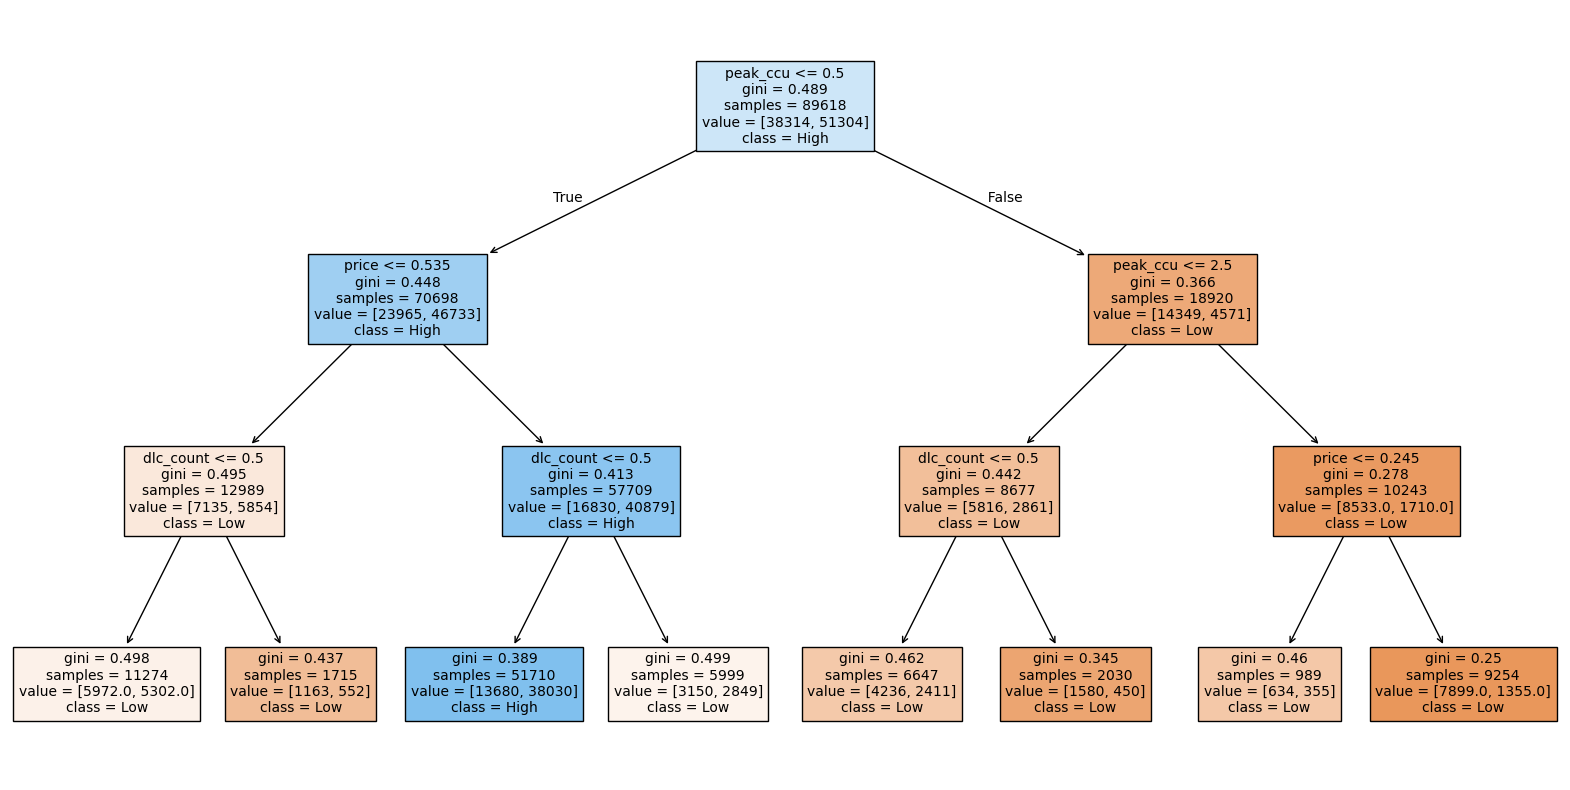

In [5]:
#creating a new column called review category that will utilize the percentage of positive
#reviews. By using lambda we will seperate high and low percentage targets for our y values.
df['review_category'] = df['pct_pos_total'].apply(lambda x: 'High' if x >= 70 else 'Low')

#selecting features for the Decision Tree
feature_cols = [
    'average_playtime_forever',
    'average_playtime_2weeks',
    'median_playtime_forever',
    'median_playtime_2weeks',
    'peak_ccu',
    'price',
    'dlc_count'
]
#variable X containing only feature columns
X = df[feature_cols]
#variable y that contains the target column
y = df['review_category']

#creating and training the desicion tree model classifier
clf = DecisionTreeClassifier(random_state=1234, max_depth=3)
model = clf.fit(X, y)

#plot the Decision Tree
plt.figure(figsize=(20, 10))
tree.plot_tree(clf, feature_names=feature_cols, class_names=['Low', 'High'], filled=True, fontsize=10)
plt.savefig("decision_tree.png", dpi=300, bbox_inches='tight')
plt.show()

The purpose of this decision tree classifier is designed to determine whether a game is likely to have High or Low review ratings based on measurable game attributes. This model analyzes numerical features and repeatedly splits the data at thresholds that best separate High-rated from Low-rated games.

In [6]:
#load data into a different dataframe
df2 = pd.read_csv("games_march2025_cleaned.csv", on_bad_lines='skip')
df2.columns = df2.columns.str.strip()

#filling missing price values and log transform function to reduce skew
df2['price'] = df2['price'].fillna(0)
df2['price'] = np.log1p(df2['price'])

#creating a balanced target: High if more positive than negative reviews, else Low
df2['review_category'] = df2.apply(lambda row: 'High' if row['positive'] > row['negative'] else 'Low', axis=1)

#features and target
X = df2[['price']]
y = df2['review_category']

#split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#train Gaussian Naive Bayes model
model = GaussianNB()
model.fit(X_train, y_train)

#predict and evaluate
y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

        High       0.73      0.90      0.81     12228
         Low       0.58      0.29      0.39      5696

    accuracy                           0.71     17924
   macro avg       0.65      0.60      0.60     17924
weighted avg       0.68      0.71      0.67     17924

Confusion Matrix:
[[11003  1225]
 [ 4038  1658]]


The purpose of this analysis is to predict whether a game is likely to receive mostly positive or negative reviews based solely on its price. This can help identify patterns such as whether more expensive games tend to be better received. The model uses the Gaussian Naive Bayes which assumes price is normally distributed within each class. And computes the probabilities for each class and predicts the one with the highest probability. 

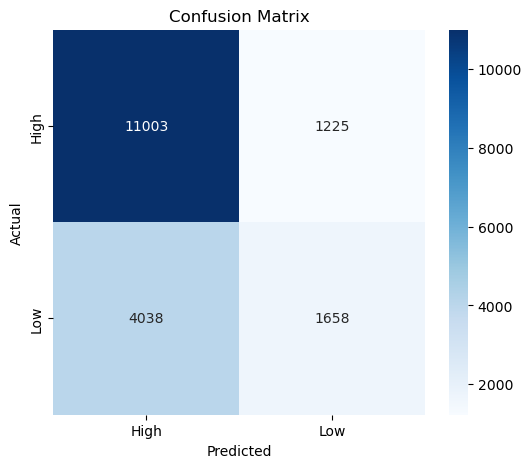

In [7]:
#compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['High', 'Low'])

#plot the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['High', 'Low'], yticklabels=['High', 'Low'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

The confusion matrix has an x-axis labeled predicted class (High or Low) and the y-axis is labeled actual class (High or Low). Within the four cells it will count the predictions, the top left predicts the true high as high (correct), the top right predicts the true high as low (misclassified). The bottom left predicts the true low as high (misclassified) and the bottom right predicts true low as low (correct).

In [8]:
#keeping only the platform columns and convert them to boolean
df_platforms = df[['windows', 'mac', 'linux']].fillna(False).astype(bool)

#run Apriori to find frequent platform combinations
frequent_itemsets = apriori(df_platforms, min_support=0.05, use_colnames=True)

#generate association rules with confidence >= 0.1
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)

#keep only rules with at least one antecedent and one consequent
rules = rules[rules['antecedents'].apply(lambda x: len(x) >= 1) & 
              rules['consequents'].apply(lambda x: len(x) >= 1)]

#function to take item set, turns into a list, then converts the list into readable strings
def is_to_str(fset):
    return ', '.join(list(fset))

#creating clean columns
rules['antecedent_str'] = rules['antecedents'].apply(is_to_str)
rules['consequent_str'] = rules['consequents'].apply(is_to_str)

#selecting and reorder columns for display
display_cols = ['antecedent_str', 'consequent_str', 'support', 'confidence', 'lift']

#display top rules
print("Association Rules:", rules.shape[0])
print(rules[display_cols].head(10).to_string(index=False))


Association Rules: 12
antecedent_str consequent_str  support  confidence     lift
       windows            mac 0.194336    0.194401 0.999073
           mac        windows 0.194336    0.998738 0.999073
       windows          linux 0.140798    0.140845 0.999622
         linux        windows 0.140798    0.999287 0.999622
         linux            mac 0.104644    0.742694 3.816881
           mac          linux 0.104644    0.537791 3.816881
windows, linux            mac 0.104633    0.743145 3.819196
  windows, mac          linux 0.104633    0.538413 3.821295
    linux, mac        windows 0.104633    0.999893 1.000228
       windows     linux, mac 0.104633    0.104668 1.000228


The purpose of this analysis is to identify patterns between platforms (Windows, Mac, Linux) in the dataset of games. If a game is available on one platform, which other platforms is it likely to be available on. This can help us understand platform relationships and can inform decisions such as marketing, cross-platform support, or targeting a multi-platform release.